Autores: Bruno Leal Fonseca & Guilherme Namen Pimenta

https://github.com/Nagi0/motor-vibration-data-mining

# Business Understanging

**Objetivo do Dataset**
O cliente, no caso a COPPE/Poli/UFRJ apresenta uma base de dados que consiste em diversas séries temporais de alta amostragem de sinais de vibração de motores, onde foram simulados desalinhamentos horizontais e verticais, com o objetivo de reproduzir o comportamento de motores que gradativamente ficam defeituosos. Os analistas responsáveis pelo projeto são: Bruno Leal Fonseca e Guilherme Namen Pimenta, ambos igualmente responsáveis pelo andamento do projeto como um todo. O resultado do trabalho será usado para avaliar/monitorar a saúde de ativos de motores 
elétricos, alertando de possíveis danos causados no equipamento. 

Usar algoritmos de agrupamento, para conseguir segmentar regimes de operação nominal de motores elétricos dos regimes defeituosos, usando sinais de vibração dos rotores. Estabelecendo fronteiras entre os níveis aceitáveis e críticos dos equipamentos, para fazer manutenções com gastos minimizados. 

**Origem dos Dados**
O dataset foi desenvolvido pela equipe da Universidade Federal do Rio de Janeiro (UFRJ) e está disponível no portal do Grupo de Monitoramento e Diagnóstico de Sistemas Mecânicos (MDS). As medições foram realizadas em um motor com um rotor a 50 kHz e armazenadas em diferentes categorias com base nos tipos e severidades das falhas introduzidas.

**Características do Dataset**
- Estrutura do Dataset: O conjunto de dados está organizado em pastas que representam diferentes condições de falha, como desalinhamento horizontal e vertical, desequilíbrio, e condições normais. Subpastas indicam níveis de severidade específicos (exemplo: 0.5 mm de desalinhamento).

- Os dados consistem em várias planilhas CSV, cada uma delas apresenta os seguintes atributos:

    - tachometer: Medição do tacômetro.
    - underhang_1, underhang_2, underhang_3: Vibrações em sensores posicionados no lado inferior.
    - overhang_1, overhang_2, overhang_3: Vibrações em sensores posicionados no lado superior.
    - microphone: Medição de som/vibração ao redor do motor.

    - Linhas: Representam instantes de tempo durante a coleta de dados. No caso a amostragem foi feita a 50 kHz. Considerando que o registro durou 5 segundos, foram obtidas 250.000 amostras por registro. No total há cerca de 40 desses registros para cada tipo de estado dos motores.

**Relação com o Problema de Negócio**
Este dataset é relevante para o diagnóstico de falhas e a manutenção preditiva de sistemas industriais. A detecção de anomalias com base em medições de vibração pode:

1. Prevenir falhas catastróficas: Identificar tendências de falhas antes que elas ocorram.
2. Reduzir custos de manutenção: Implementar estratégias baseadas na condição real do motor, evitando manutenções desnecessárias.
3. Melhorar a eficiência operacional: Garantir o funcionamento contínuo e otimizado de sistemas industriais.
4. Redução de gastos com falhas inesperadas: Quando um motor falha, há grandes despesas para substituição parcial ou total do equipamento, além do prejuízo da produção ficar parada durante a inesperada manutenção e realocação de colaboradores

**Próximos Passos**
Com este entendimento inicial, podemos:

1. Primeiramente, será necessário reduzir um pouco o tamanho da base de dados, pelo fato de cada registro ser muito extenso e haverem diversos tipos de falhas que podem ocorrer, algumas delas serão simplificadas. As falhas do tipo Overhang e Underhang serão limitadas a apenas o tipo 'ball_fault'. Além disso, serão considerados os 3 piores cenários para cada tipo de falha.
2. Processar os dados para gerar atributos descritivos que capturam o comportamento vibracional do motor.
3. Aplicar algoritmos de agrupamento, como DBSCAN, para identificar padrões e possíveis anomalias.
4. Validar a eficácia do agrupamento utilizando os rótulos originais (normal e falhas), aplicando métricas de avaliação externas.

# Data Understanding & Data Preparation

A primeira coisa a ser feita é pensar como os dados devem ser tratados para os algoritmos de agrupamento. Como a base consiste em um número muito grande de registros, será feita uma engenharia de atributos para achar características que descrevem bem os sinais temporais. Usar os dados temporais provou-se ser muito ineficiente, pois mesmo falhas expressivas podem ser imperceptíveis no domínio do tempo.

Portanto, para cada planilha CSV foram extraídas características do sinal, depois todas elas são concatenadas em um único dataframe para ser levado à modelagem. Foram totalizadas 709 arquivos CSV (cada uma com 250.00 linhas), cada uma será tratada como um único registro no dataframe de atributos estimados.

Foi utilizada a Transformada Rápida de Fourrier (FFT), para extrair características do domínio da frequência, obtendo os harmônicos mais expressivos e suas frequências é possível descrever bem a vibração dos motores. Sinais temporais de alta amostragem, tal como vibração e corrente elétrica, tendem a ser bem consistentes, na presença de uma anomalia, os harmônicos tendem a deslocar ou mudar de módulo, também é possível que novos harmônicos apareçam indicando a falha. A imagem abaixo ilustra isso:

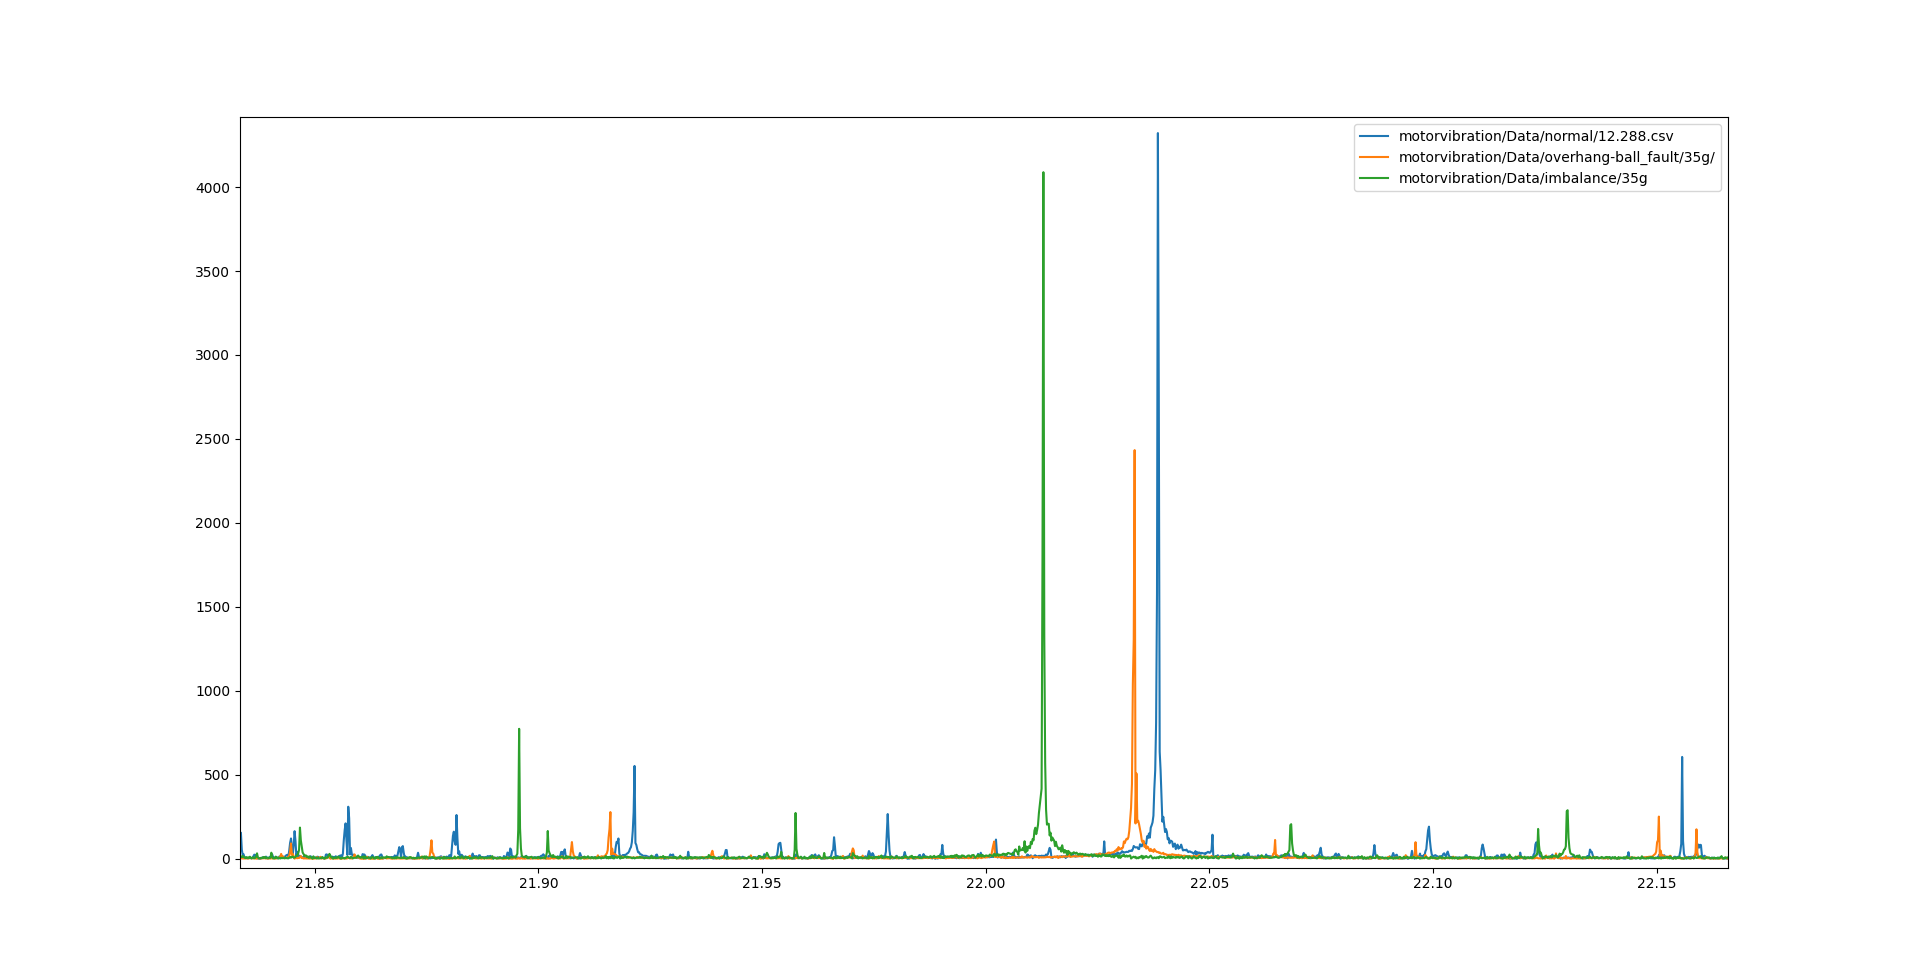

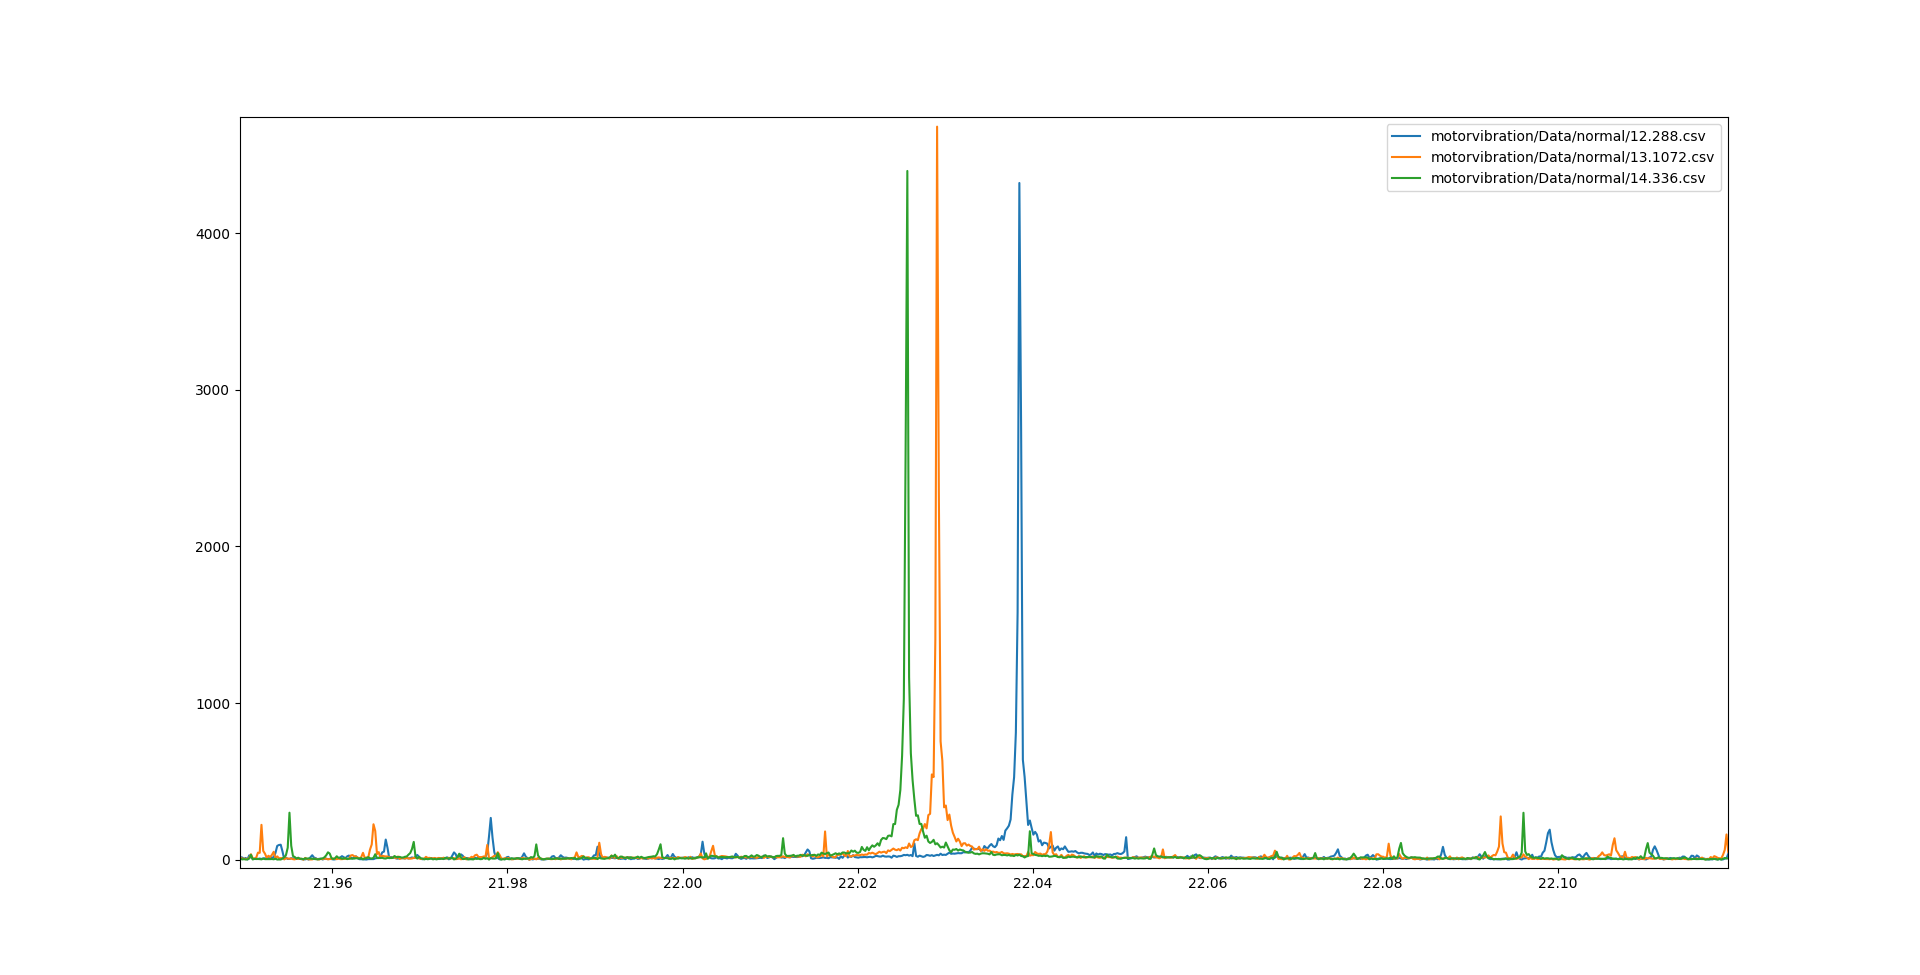

A base de dados original apresenta 8 colunas que foram medições de variáveis físicas por instrumentação, sendo duas delas o tacômetro medindo a velocidade e a outra o microfone medindo o ruído do rotor. 
Foram então selecionados os 500 harmônicos mais expressivos, pegando o módulo e frequência na qual ocorreram. Isso foi feito para cada uma das 8 colunas.

In [ ]:
def get_spectrum(self, p_y: np.ndarray) -> pl.DataFrame:
        yf = fftpack.fft(p_y)
        xf = fftpack.fftfreq(len(p_y), 1 / self.frequency_hz)
        spectrum_df = pl.DataFrame({"xf": xf, "yf": np.abs(yf)})

        return spectrum_df

def get_greatests_harmonics(self, p_df: pl.DataFrame, top_n: int, p_min_freq: float) -> pl.DataFrame:
    p_df = p_df.lazy().filter(pl.col("xf") > p_min_freq).collect()
    return p_df.sort(by="yf", descending=True).head(top_n)

def get_top_harmonics(
    self, p_name: str, p_df: pl.DataFrame, p_target_feature: str, p_freq_thresh: float, p_top_harmonics: int
) -> pl.DataFrame:
    spectrum_feat = {"file_name": p_name}
    spectrum_df = self.get_spectrum(p_df[p_target_feature].to_numpy())
    spectrum_df = self.get_greatests_harmonics(spectrum_df, p_top_harmonics, p_freq_thresh)

    for idx in range(p_top_harmonics):
        spectrum_feat[f"{p_target_feature}_harmonic_{idx+1}_frequency"] = spectrum_df.row(idx, named=True)["xf"]
        spectrum_feat[f"{p_target_feature}_harmonic_{idx+1}"] = spectrum_df.row(idx, named=True)["yf"]

    return pl.DataFrame(spectrum_feat)

Outra forma eficaz de extrair características de um sinal temporal são as Transformadas Wavelets. Similares à FFT, onde é feita uma decomposição de um sinal no domínio do tempo em diferentes componentes no domínio da frequência, as Transformadas Wavelets apresentam a virtude de não dependerem somente das funções seno e cosseno para encontrar essas componentes.

Há uma ampla gama de funções que podem ser aplicadas nessa tarefa e elas podem contribuir para realçar diferentes características do sinal de vibração. A chamada Wavelet-Mãe é a função oscilatória que será usada para caracterizar o sinal na discretização. Foi escolhida uma Wavelet da família Daubechies (db4), com ela serão extraídas tendencias nas baixas e altas frequências. O sinal pode ser separado em níveis ao ser decomposto, cada qual indicando componentes mais e mais específicos sobre o sinal.

A Transformada Wavelet retorna os coeficientes que compõem o sinal discretizado, trazendo assim os atributos que os caracteriza. Todavia, o problema de alta dimensionalidade se torna preocupante, já foram extraídos diversos harmônicos da FFT, e concatenar uma quantidade grandes de componentes pode ser problemático, pois como visto nas aulas, à medida que as dimensões aumentam, o centro do espaço de características vai ficando oco, e os pontos vão para as extremidades. Outro problema proveniente de uma dimensionalidade muito maior é que os pontos nas extremidades do espaço ficam equidistantes do centro, isso faz com que as medidas de distância usadas nos algoritmos de agrupamento fiquem ainda menos eficientes.

Logo, a saída foi estimar algumas estatísticas básicas dos componentes obtidos pela Transformada Wavelet.

In [ ]:
def get_wavelet_features(self, p_signal: np.ndarray, p_target: str, p_wavelet="db2", p_levels=4):
    # Decompor o sinal em níveis usando DWT
    coeffs = pywt.wavedec(p_signal, p_wavelet, level=p_levels)

    features = {}

    # Para cada nível de decomposição (aproximação e detalhes)
    for i, coeff in enumerate(coeffs):
        # Estatísticas dos coeficientes
        features[f"{p_target}_level_{i}_mean"] = np.mean(coeff)
        features[f"{p_target}_level_{i}_std"] = np.std(coeff)
        features[f"{p_target}_level_{i}_energy"] = np.sum(coeff**2)
        features[f"{p_target}_level_{i}_kurtosis"] = np.mean((coeff - np.mean(coeff)) ** 4) / (np.std(coeff) ** 4)
        features[f"{p_target}_level_{i}_skewness"] = np.mean((coeff - np.mean(coeff)) ** 3) / (np.std(coeff) ** 3)

    return pl.DataFrame(features)

Também foram estimadas algumas estatísticas de básicas no domínio do tempo, são elas: 
- min
- max
- mean
- var
- kurtosis
- skewness
- entropy

Essas estatísticas podem ser muito úteis no agrupamento, pois nota-se que em cada planilha CSV o experimento foi diferente, os valores de velocidade do tacômetro e as vibrações se comportam de maneiras diferentes, indicando que o motor pode ter sido colocado para rotacionar em regimes variados, com essas estatísticas básicas, o agrupamento pode ganhar uma camada de robustez ao levar em conta uma representação direta das variáveis físicas.

In [ ]:
def get_stats_features(self, p_df: pl.DataFrame, p_target_feature: str) -> pl.DataFrame:
    feat_dict = {}

    df = p_df.with_columns(
        [
            pl.col(p_target_feature).min().alias("min"),
            pl.col(p_target_feature).max().alias("max"),
            pl.col(p_target_feature).mean().alias("mean"),
            pl.col(p_target_feature).var().alias("var"),
            pl.col(p_target_feature).kurtosis().alias("kurtosis"),
            pl.col(p_target_feature).skew().alias("skewness"),
            pl.col(p_target_feature).abs().entropy(base=2).alias("entropy"),
        ]
    )
    feat_dict[f"{p_target_feature}_min"] = df["min"][0]
    feat_dict[f"{p_target_feature}_max"] = df["max"][0]
    feat_dict[f"{p_target_feature}_mean"] = df["mean"][0]
    feat_dict[f"{p_target_feature}_var"] = df["var"][0]
    feat_dict[f"{p_target_feature}_kurtosis"] = df["kurtosis"][0]
    feat_dict[f"{p_target_feature}_skewness"] = df["skewness"][0]
    feat_dict[f"{p_target_feature}_entropy"] = df["entropy"][0]

    return pl.DataFrame(feat_dict)

O código completo do gerador de atributos segue abaixo:

In [ ]:
from dataclasses import dataclass
import numpy as np
import polars as pl
from scipy import fftpack
import pywt
import matplotlib.pyplot as plt


@dataclass
class FeatureEngineering:
    dataset: pl.DataFrame
    frequency_hz: float

    def filter_operations(self, p_df: pl.DataFrame, p_operations_list: list):
        filtered_df_list = []
        for operation in p_operations_list:
            df = p_df.lazy().filter(pl.col("file_name").str.contains(f"{operation}")).collect()
            filtered_df_list.append((df, operation))

        return filtered_df_list

    def plot_features(self, p_column: str, p_motor_operations: list):
        filterd_dataset = self.dataset[[p_column, "file_name"]]
        filterd_dataset_list = self.filter_operations(filterd_dataset, p_motor_operations)

        legend = []
        plt.figure()
        for operation_df, operation_name in filterd_dataset_list:
            plt.plot(operation_df[p_column])
            legend.append(operation_name)
        plt.legend(legend)
        plt.show()

    def get_wavelet_features(self, p_signal: np.ndarray, p_target: str, p_wavelet="db2", p_levels=4):
        # Decompor o sinal em níveis usando DWT
        coeffs = pywt.wavedec(p_signal, p_wavelet, level=p_levels)

        features = {}

        # Para cada nível de decomposição (aproximação e detalhes)
        for i, coeff in enumerate(coeffs):
            # Estatísticas dos coeficientes
            features[f"{p_target}_level_{i}_mean"] = np.mean(coeff)
            features[f"{p_target}_level_{i}_std"] = np.std(coeff)
            features[f"{p_target}_level_{i}_energy"] = np.sum(coeff**2)
            features[f"{p_target}_level_{i}_kurtosis"] = np.mean((coeff - np.mean(coeff)) ** 4) / (np.std(coeff) ** 4)
            features[f"{p_target}_level_{i}_skewness"] = np.mean((coeff - np.mean(coeff)) ** 3) / (np.std(coeff) ** 3)

        return pl.DataFrame(features)

    def get_spectrum(self, p_y: np.ndarray) -> pl.DataFrame:
        yf = fftpack.fft(p_y)
        xf = fftpack.fftfreq(len(p_y), 1 / self.frequency_hz)
        spectrum_df = pl.DataFrame({"xf": xf, "yf": np.abs(yf)})

        return spectrum_df

    def get_greatests_harmonics(self, p_df: pl.DataFrame, top_n: int, p_min_freq: float) -> pl.DataFrame:
        p_df = p_df.lazy().filter(pl.col("xf") > p_min_freq).collect()
        return p_df.sort(by="yf", descending=True).head(top_n)

    def get_top_harmonics(
        self, p_name: str, p_df: pl.DataFrame, p_target_feature: str, p_freq_thresh: float, p_top_harmonics: int
    ) -> pl.DataFrame:
        spectrum_feat = {"file_name": p_name}
        spectrum_df = self.get_spectrum(p_df[p_target_feature].to_numpy())
        spectrum_df = self.get_greatests_harmonics(spectrum_df, p_top_harmonics, p_freq_thresh)

        for idx in range(p_top_harmonics):
            spectrum_feat[f"{p_target_feature}_harmonic_{idx+1}_frequency"] = spectrum_df.row(idx, named=True)["xf"]
            spectrum_feat[f"{p_target_feature}_harmonic_{idx+1}"] = spectrum_df.row(idx, named=True)["yf"]

        return pl.DataFrame(spectrum_feat)

    def get_stats_features(self, p_df: pl.DataFrame, p_target_feature: str) -> pl.DataFrame:
        feat_dict = {}

        df = p_df.with_columns(
            [
                pl.col(p_target_feature).min().alias("min"),
                pl.col(p_target_feature).max().alias("max"),
                pl.col(p_target_feature).mean().alias("mean"),
                pl.col(p_target_feature).var().alias("var"),
                pl.col(p_target_feature).kurtosis().alias("kurtosis"),
                pl.col(p_target_feature).skew().alias("skewness"),
                pl.col(p_target_feature).abs().entropy(base=2).alias("entropy"),
            ]
        )
        feat_dict[f"{p_target_feature}_min"] = df["min"][0]
        feat_dict[f"{p_target_feature}_max"] = df["max"][0]
        feat_dict[f"{p_target_feature}_mean"] = df["mean"][0]
        feat_dict[f"{p_target_feature}_var"] = df["var"][0]
        feat_dict[f"{p_target_feature}_kurtosis"] = df["kurtosis"][0]
        feat_dict[f"{p_target_feature}_skewness"] = df["skewness"][0]
        feat_dict[f"{p_target_feature}_entropy"] = df["entropy"][0]

        return pl.DataFrame(feat_dict)

    def plot_spectrum(self, p_column: str, p_motor_operations: list, p_freq_thresh: float):
        filterd_dataset = self.dataset[[p_column, "file_name"]]
        filterd_dataset_list = self.filter_operations(filterd_dataset, p_motor_operations)

        legend = []
        _, ax = plt.subplots()

        for operation_df, operation_name in filterd_dataset_list:
            spectrum_df = self.get_spectrum(operation_df[p_column].to_numpy())
            spectrum_df = spectrum_df.lazy().filter(pl.col("xf") > p_freq_thresh).collect()

            ax.plot(spectrum_df["xf"], spectrum_df["yf"])
            legend.append(operation_name)
        plt.legend(legend)
        plt.show()

In [ ]:
import os
from glob import glob
from dataclasses import dataclass
from ast import literal_eval
from dotenv import load_dotenv
from tqdm import tqdm
import polars as pl
from featureEngineering import FeatureEngineering


@dataclass
class DataLoader:
    dataset_path: str

    def list_files(self) -> list:
        csv_files_list = []

        folders_list = os.listdir(self.dataset_path)
        for folder in folders_list:
            folder_path = os.path.join(self.dataset_path, folder)
            if os.path.isdir(folder_path):
                sub_folders_list = os.listdir(folder_path)
                for sub_folder in sub_folders_list:
                    sub_folder_path = os.path.join(folder_path, sub_folder)
                    if os.path.isdir(sub_folder_path):
                        list_csv = glob(f"{sub_folder_path}/*.csv")
                        for csv_file in list_csv:
                            csv_files_list.append((csv_file, csv_file))
                    elif sub_folder_path.endswith(".csv"):
                        csv_files_list.append((sub_folder_path, sub_folder_path))

        return csv_files_list

    def get_feats_multiple_targets(
        self,
        p_df: pl.DataFrame,
        p_file: str,
        p_feat_eng: FeatureEngineering,
        p_targets_list: list,
        p_freq_thresh: float,
        p_top_harmonics: int,
    ):
        feats_list = []
        for target in p_targets_list:
            wavelet_feat = p_feat_eng.get_wavelet_features(p_df[f"{target}"].to_numpy(), target)
            stats_feat = p_feat_eng.get_stats_features(p_df, target)
            spectrum_feat = p_feat_eng.get_top_harmonics(
                p_file.replace("\\", "/"), p_df, target, p_freq_thresh, p_top_harmonics
            )
            all_feats = pl.concat([spectrum_feat, wavelet_feat, stats_feat], how="horizontal")
            feats_list.append(all_feats)

        return feats_list

    def load_dataset(
        self, p_target_features: str, p_sample_rate: int, p_freq_thresh: float, p_top_harmonics: int
    ) -> pl.DataFrame:
        csv_files_list = self.list_files()
        dataframes_list = []

        for file, sub_folder in tqdm(csv_files_list):
            sub_folder = sub_folder.replace("\\", "/")
            df = pl.read_csv(file, has_header=False, new_columns=literal_eval(os.environ["dataset_columns_name"]))
            feat_eng = FeatureEngineering(df, p_sample_rate)

            feats_list = self.get_feats_multiple_targets(
                df, file, feat_eng, p_target_features, p_freq_thresh, p_top_harmonics
            )

            spectrum_feats_df = pl.concat(feats_list, how="align")
            # spectrum_feats_df = self.get_fftconv_features(feat_eng, df, file)

            dataframes_list.append(spectrum_feats_df)

        full_df = pl.concat(dataframes_list)

        return full_df


if __name__ == "__main__":
    load_dotenv("motorvibration/config/.env")
    data_loader = DataLoader(os.environ["dataset_path"])
    dataset = data_loader.load_dataset(
        literal_eval(os.environ["target_feature"]), p_sample_rate=50000, p_freq_thresh=1000.0, p_top_harmonics=500
    )
    print(dataset)

    dataset.write_csv(f"{os.environ["dataset_path"]}/motor_vibration_dataset.csv")


Em seguida será feita a modelagem, nessa etapa será aplicado um algoritmo de agrupamento para que seja possível tentar discernir o conjunto de dados anômalos da operação normal. Primeiramente, para fins de visualização será plotado os datapoints em um eixo cartesiano, os eixos serão a frequência do harmônico mais expressivo e o respectivo módulo sobre a coluna de medição de vibração Overhang3. Dessa forma, será possível ter uma noção básica de como os atributos no domínio da frequência podem caracterizar o conjunto de dados.

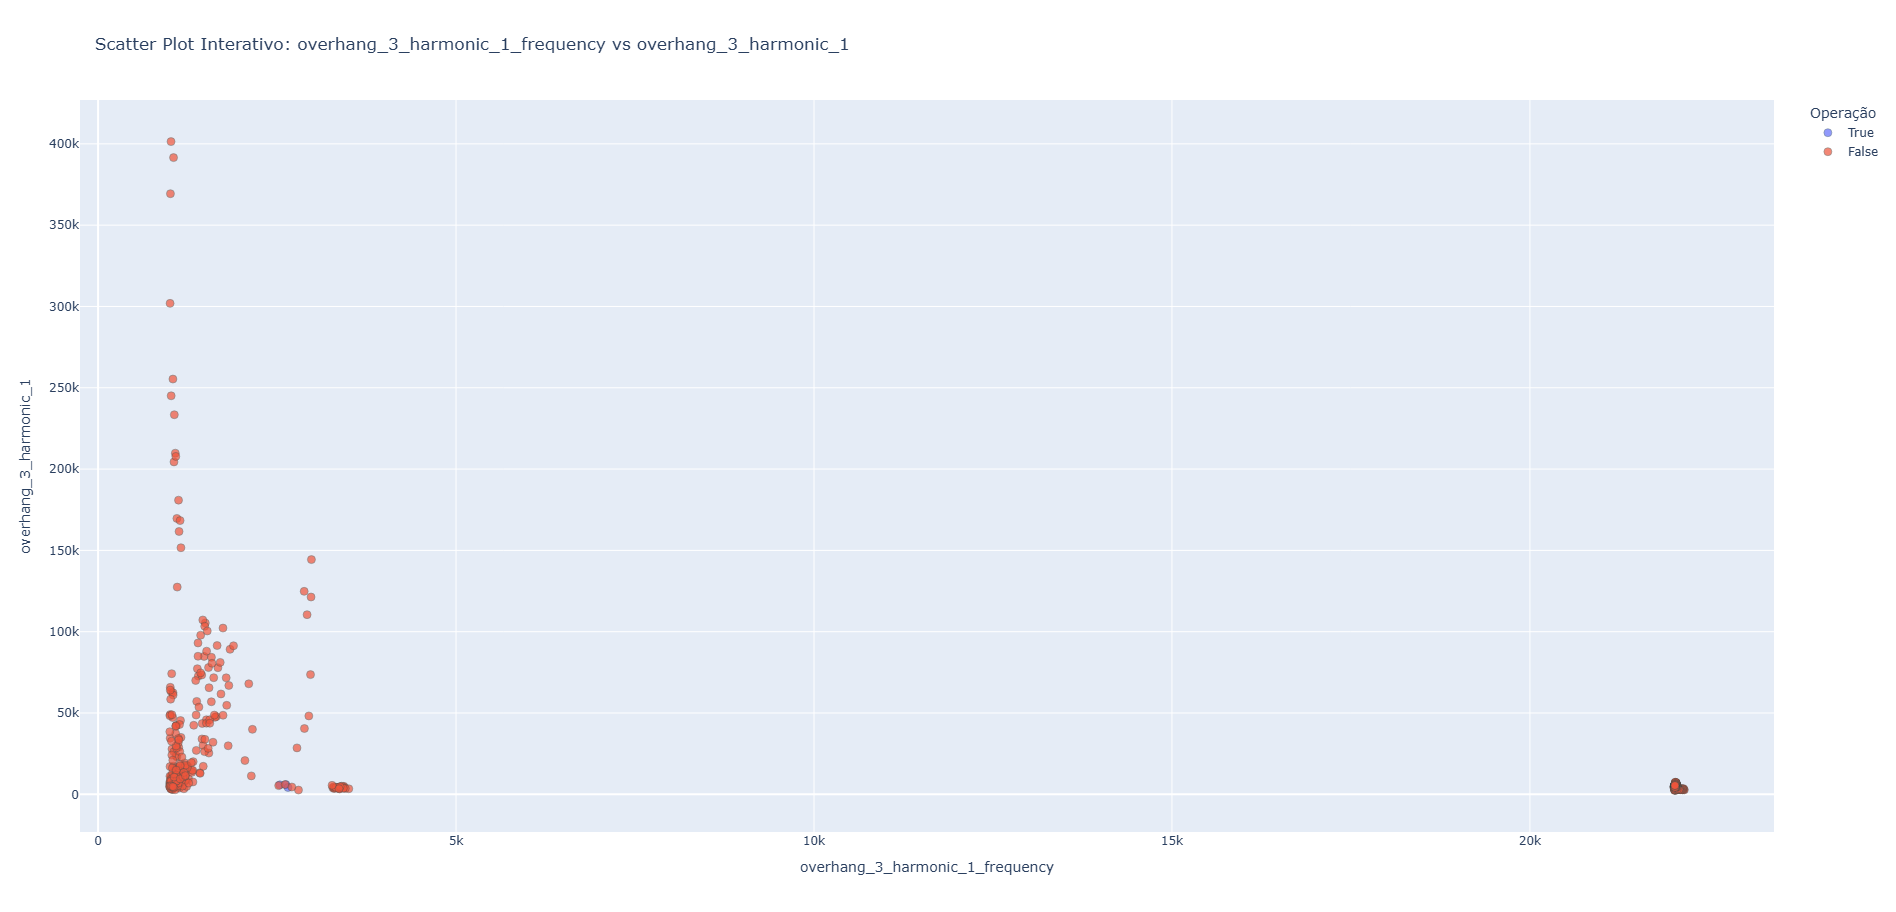

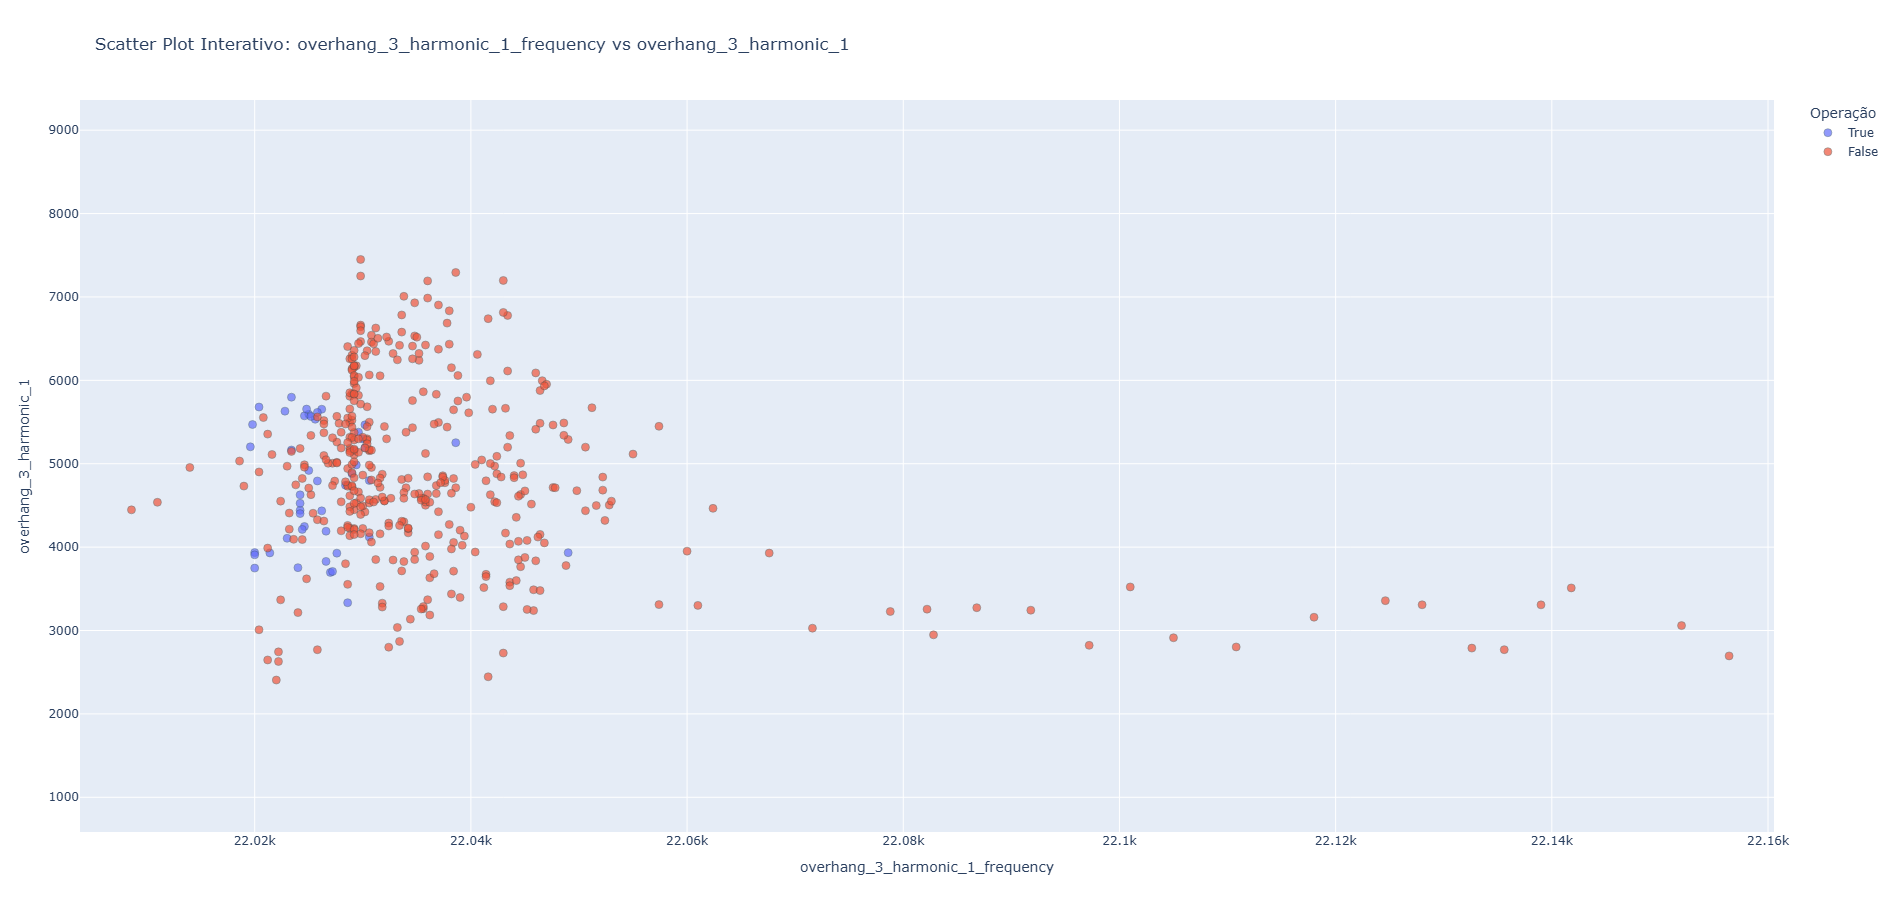

Ampliando no pequeno agrupamento na esquerda, é possível evidenciar que a maior parte dos dados de operação normal se aglomeram nessa região, junto de outros dados anômalos. Pode-se concluir que os harmônicos podem sim ajudar a discernir anomalias e operação nominal, contudo, apenas o harmônico mais expressivo está longe de ser suficiente para um agrupamento que permita discernir as classes.

Após a base de dados com as features estimadas para cada CSV ter sido carregada, o primeiro passo foi normalizar a base de dados. Contudo a base não foi normalizada levando em conta toda as amostras, mas usando os valores de operação normal como referência. Aplicando o MinMax Scaler, cada atributo foi normalizado em um range de 0.0 a 1.0, considerando os respectivos valores mínimo e máximo de cada atributo. Como se espera que o motor esteja operando normalmente, a base foi normalizada tendo a operação normal como referência e tudo fora desse range pode ser considerado anômalo.

Todavia, tendo uma base de dados de dimensões tão elevada, deseja-se saber se os atributos estimados foram suficientes para separar as classes de rótulos. Uma alternativa é usar o UMAP (Uniform Manifold Approximation and Projection), que consistem em uma técnica de redução de dimensionalidade que funciona para casos lineares, tal como o t-SNE, mas também casos gerais onde há não linearidade.

## Fundamentos Matemáticos

O UMAP utiliza conceitos de:

1. **Geometria Diferencial**: Define uma métrica Riemanniana nos dados para modelar sua estrutura local.
2. **Teoria de Grafos**: Constrói um grafo baseado em vizinhos próximos para capturar relações locais.
3. **Topologia Algébrica**: Relaciona a estrutura de alta dimensão ao grafo resultante.

### Etapas do Algoritmo

1. **Construção do Grafo de Similaridade**:
   - Cada ponto no espaço original é considerado como um nó no grafo.
   - Define-se um conjunto de vizinhos próximos usando a métrica **k-nearest neighbors (k-NN)**.
   - Uma função de afinidade (ou probabilidade) é atribuída às arestas do grafo para medir a similaridade entre pontos.

2. **Redução de Dimensionalidade**:
   - O grafo de alta dimensão é aproximado em um espaço de menor dimensão.
   - A otimização é feita através da minimização de uma **função de perda** que compara a estrutura dos grafos nos dois espaços (original e reduzido).

---

## Principais Características

- **Preservação de Estruturas Locais**: UMAP prioriza manter vizinhanças próximas no espaço reduzido.
- **Flexibilidade**: Suporta dados de diferentes métricas de distância, como Euclidiana, Manhattan, entre outras.
- **Velocidade**: É mais rápido que algoritmos como o t-SNE para grandes conjuntos de dados.
- **Parâmetros Importantes**:
  - *n_neighbors*: Controla o tamanho da vizinhança local.
  - *min_dist*: Define a distância mínima entre os pontos no espaço reduzido.
  - *metric*: Métrica de distância usada.

---

## Comparação com t-SNE

| Aspecto                  | UMAP                        | t-SNE                       |
|--------------------------|-----------------------------|-----------------------------|
| **Tempo de execução**     | Mais rápido                | Mais lento                  |
| **Escalabilidade**        | Melhor                     | Menor                       |
| **Preservação Global**    | Melhor equilíbrio global   | Focado em estruturas locais |
| **Parâmetros**            | Mais configuráveis         | Menos configuráveis         |

---

## Aplicações

- **Visualização de Dados**: Exploração de conjuntos de dados de alta dimensionalidade, como embeddings de redes neurais.
- **Pré-processamento**: Redução de dimensionalidade antes de aplicar algoritmos de aprendizado supervisionado ou não supervisionado.
- **Análise de Dados de Genômica**: Em bioinformática para análise de expressão gênica.
- **Processamento de Linguagem Natural**: Redução de embeddings de palavras ou frases.

Aplicando o UMAP com os dados normalizados, conforme mencionado anteriormente, e utilizando a métrica de distância Manhattan nos hiperparâmetros, obteve-se o seguinte resultado:

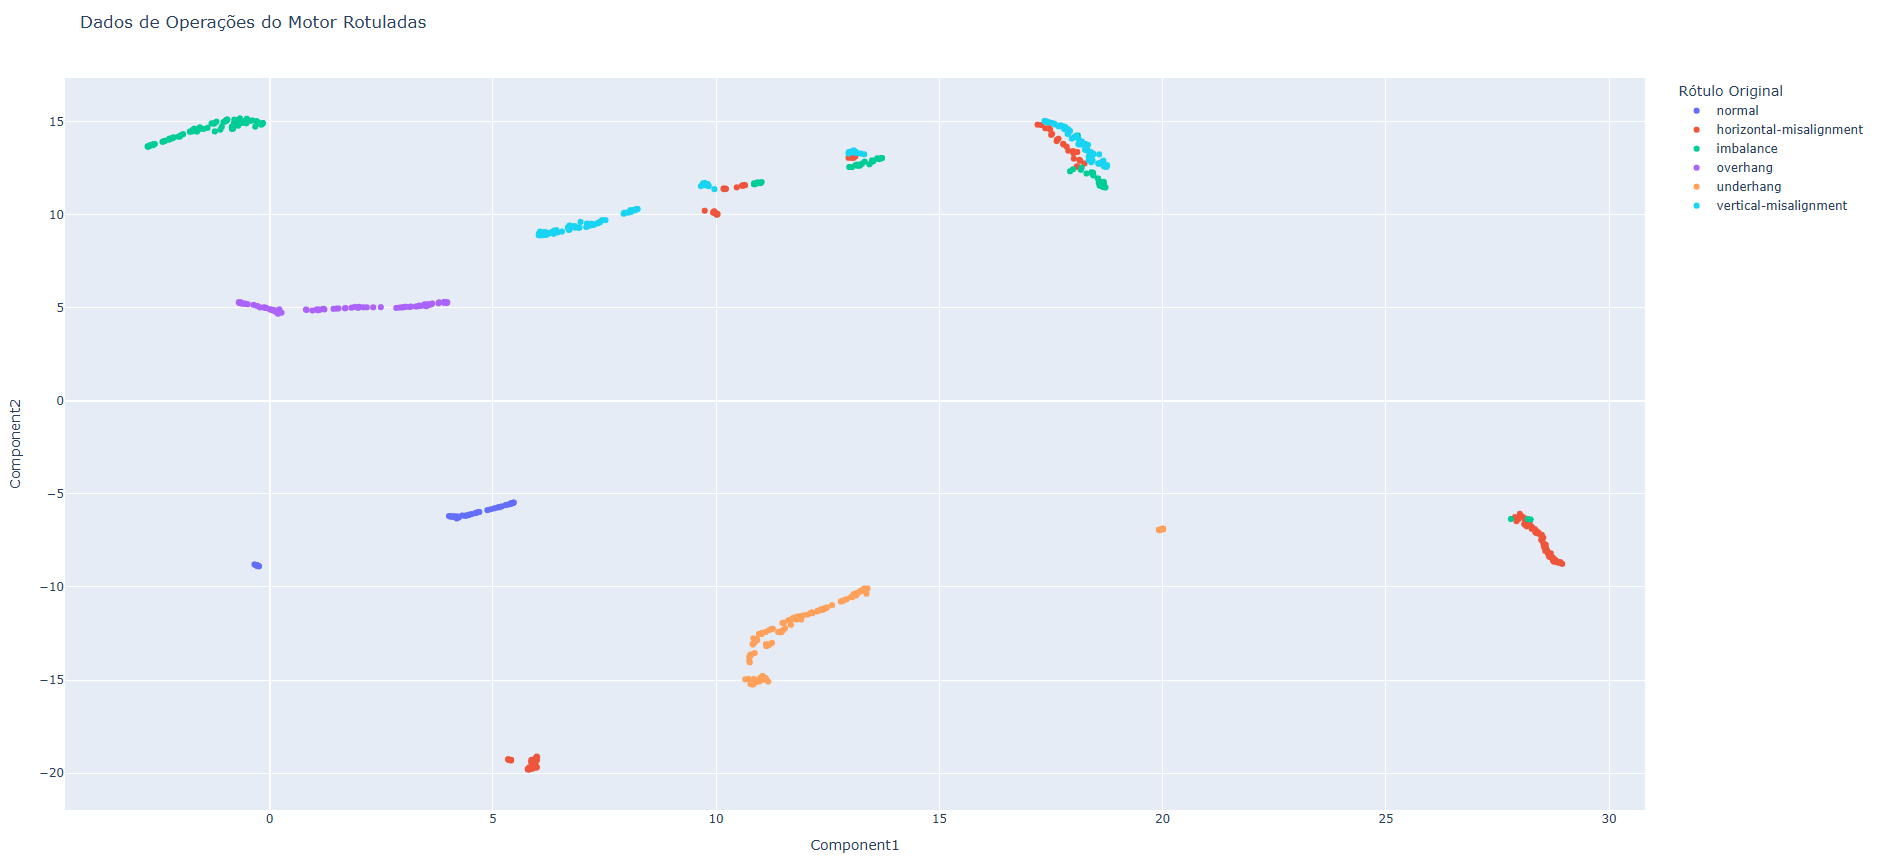

# Modeling

Agora com as features estimadas, dados visualizados e mais bem entendidos, pode-se dar inicio ao processo de modelagem. Primeiro será feita um agrupamento que visa identificar se o motor está operando de forma saudável (normal) ou se na há alguma das anomalias listadas. Portanto, o objetivo é encontrar dois agrupamentos:

- Operação Normal
- Operação Anômala

É possível validar que foi possível separar os dados de operações normais dos demais, alguns regimes de operação anômala ficam, inclusive, bem caracterizados no espaço de característica. É claro que o UMAP realizar uma redução de dimensionalidade, portanto não é uma representação 100% fiel do espaço de características, mas é possível ter uma noção da eficácia da engenharia de features.

Transformando os rótulos em binários para avaliar se o agrupamento consegue distinguir bem entre comportamento anômalo e normal:

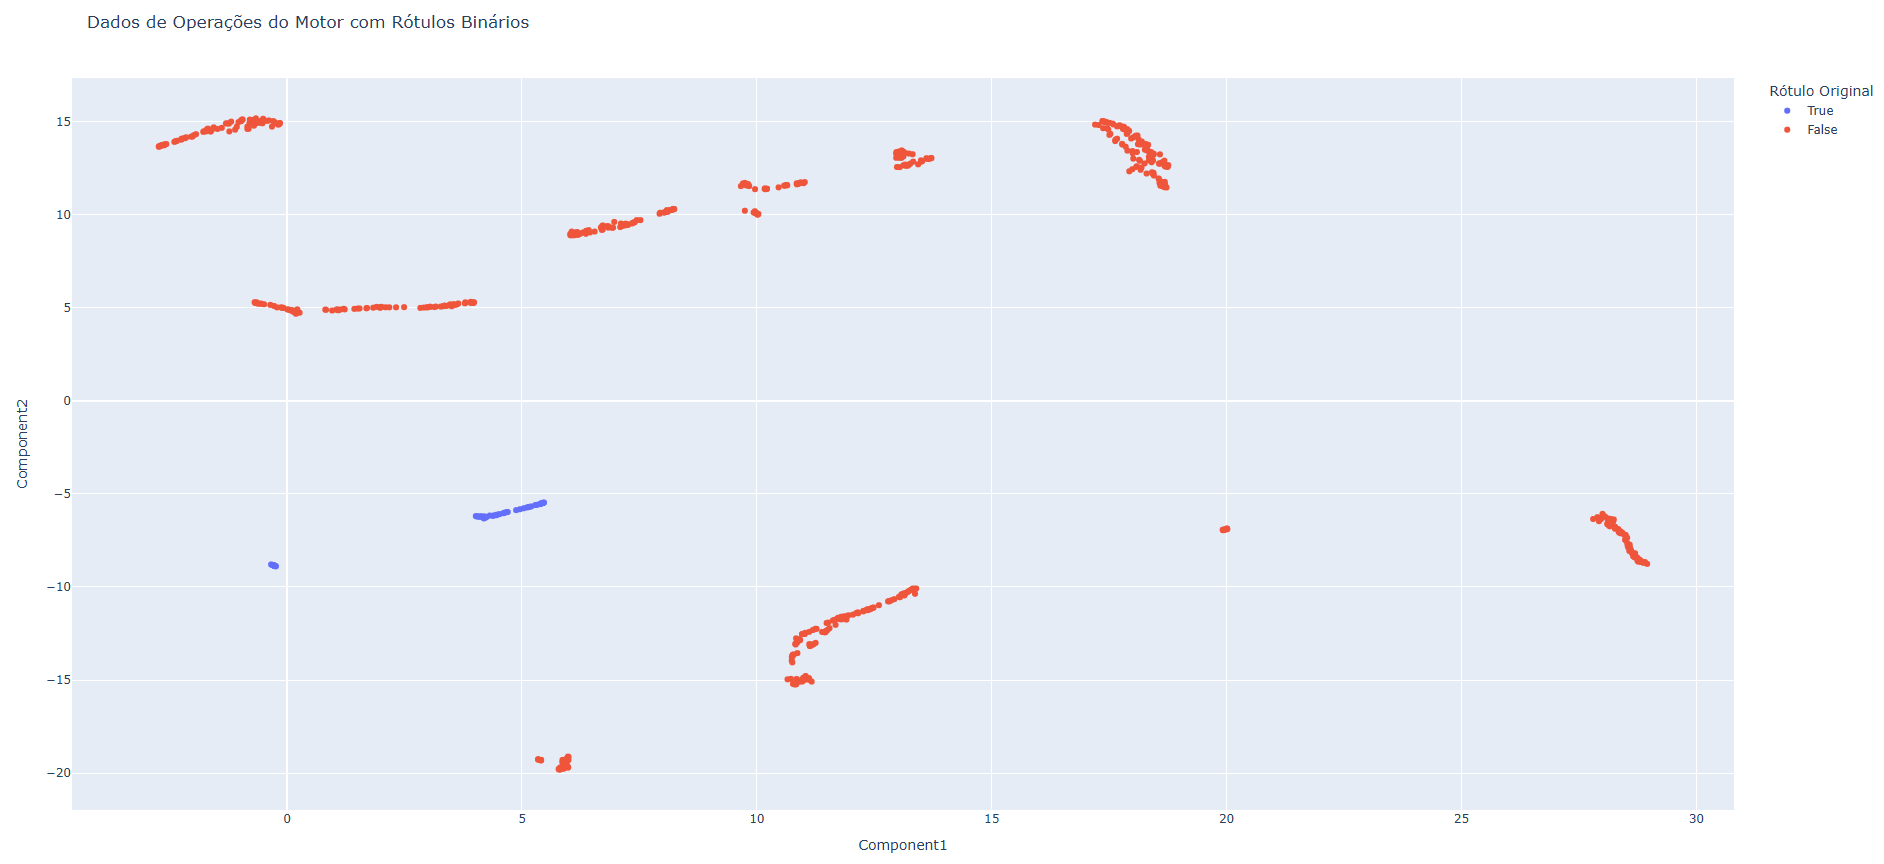

Por fim, foi aplicado o algoritmo DBSCAN para fazer o agrupamento, esse algoritmo consiste em uma técnica de agrupamento por densidade, utilizando a distância euclidiana, ajustando os hiperparâmetros até achar uma ajuste ideal. Esse algoritmo pode ser muito adequado no contexto de detectar anomalias, pois os dados de operação normal ficam bem próximos e bem caracterizados, já os demais se destoam, podendo inclusive serem detectados como "ruídos" pelo algoritmo.

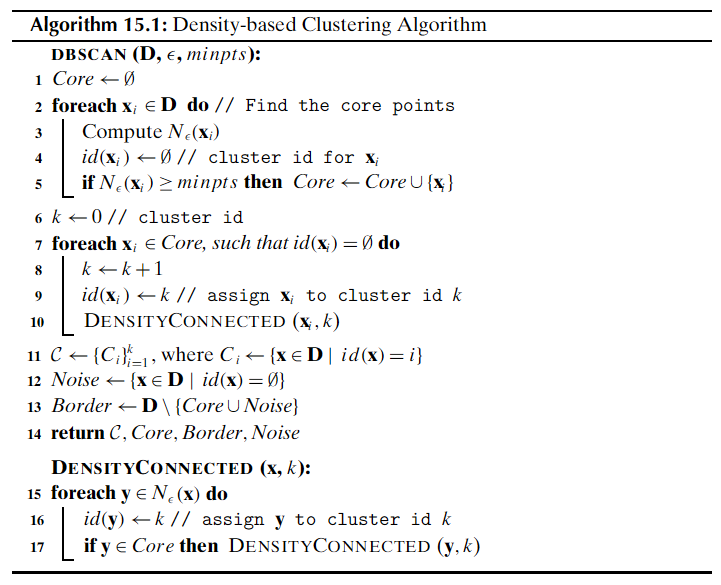

Fonte: https://dataminingbook.info/book_html/chap15/book.html, acesso em 19/12/2024

In [ ]:
import os
from ast import literal_eval
from dataclasses import dataclass
from dotenv import load_dotenv
import numpy as np
import polars as pl
import pandas as pd
import umap
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    v_measure_score,
    davies_bouldin_score,
    silhouette_score,
    calinski_harabasz_score,
)
import plotly.express as px


@dataclass
class Model:
    dataset_path: str

    def filter_motor_operation(self, p_df: pl.DataFrame, p_name: str) -> pl.DataFrame:
        return p_df.lazy().filter(pl.col("label") == p_name).collect()

    def filter_not_motor_operation(self, p_df: pl.DataFrame, p_name: str) -> pl.DataFrame:
        return p_df.lazy().filter(pl.col("label") != p_name).collect()

    def create_class_labels(self, p_df: pl.DataFrame, p_labels_name_list: list) -> np.array:
        labeled_df_list = []

        for label_name in p_labels_name_list:
            df = p_df.lazy().filter(pl.col("file_name").str.contains(f"{label_name}")).collect()
            df = df.with_columns(pl.lit(label_name).alias("label"))
            labeled_df_list.append(df)

        return pl.concat(labeled_df_list)

    def load_dataset(self):
        return pl.read_csv(self.dataset_path)

    def get_min_max_normalizer(self, p_df: pd.DataFrame) -> MinMaxScaler:
        return MinMaxScaler().fit(p_df)

    def normalize_data(self, p_df: pd.DataFrame):
        scaler = self.get_min_max_normalizer(p_df)
        return scaler, scaler.transform(p_df)

    def apply_normalizer(self, p_df: pd.DataFrame, p_scaler: MinMaxScaler):
        return p_scaler.transform(p_df)


if __name__ == "__main__":
    load_dotenv("motorvibration/config/.env")
    model = Model("motorvibration/Data/motor_vibration_dataset.csv")
    dataset = model.load_dataset()

    dataset = model.create_class_labels(dataset, literal_eval(os.environ["labels_list"]))

    normal_operation_df = model.filter_motor_operation(dataset, "normal")
    normal_operation_df = normal_operation_df.with_columns(pl.lit(True).alias("normal_operation"))

    not_normal_operation_df = model.filter_not_motor_operation(dataset, "normal")
    not_normal_operation_df = not_normal_operation_df.with_columns(pl.lit(False).alias("normal_operation"))

    all_motor_operations_df = pl.concat([normal_operation_df, not_normal_operation_df])
    print(all_motor_operations_df)

    harmonic = 1
    x_column = f"overhang_3_harmonic_{harmonic}_frequency"
    y_column = f"overhang_3_harmonic_{harmonic}"
    fig = px.scatter(
        all_motor_operations_df,
        x=x_column,
        y=y_column,
        color="normal_operation",
        hover_data=["file_name"],
        title=f"Scatter Plot Interativo: {x_column} vs {y_column}",
        labels={"normal_operation": "Operação Normal"},
    )
    fig.update_traces(marker=dict(size=8, opacity=0.7, line=dict(width=0.5, color="DarkSlateGrey")))
    fig.update_layout(
        xaxis_title=x_column,
        yaxis_title=y_column,
        legend_title="Operação",
    )
    fig.show()

    training_data = all_motor_operations_df.drop(["file_name", "label", "normal_operation"]).to_pandas()

    scaler, normal_data_scaled = model.normalize_data(
        normal_operation_df.drop(["file_name", "label", "normal_operation"]).to_pandas()
    )
    training_data_scaled = model.apply_normalizer(training_data, scaler)

    reducer = umap.UMAP(metric="manhattan", random_state=42)
    embeddings = reducer.fit_transform(
        X=training_data_scaled, y=all_motor_operations_df["normal_operation"].to_numpy()
    )

    plot_data = pd.DataFrame(embeddings, columns=["Component1", "Component2"])
    plot_data["Label"] = all_motor_operations_df["label"].to_numpy()

    fig = px.scatter(
        plot_data,
        x="Component1",
        y="Component2",
        color="Label",
        title="Dados de Operações do Motor Rotuladas",
        labels={"Anomaly": "É Anômalo", "Label": "Rótulo Original"},
    )

    fig.update_traces(marker=dict(size=6, opacity=1.0))
    fig.update_layout(scene=dict(xaxis_title="PCA1", yaxis_title="PCA2"))
    fig.show()

    dbscan = DBSCAN(eps=30.0, min_samples=10)
    y_pred = dbscan.fit_predict(training_data_scaled)

    ari = adjusted_rand_score(all_motor_operations_df["normal_operation"].to_numpy(), y_pred)
    nmi = normalized_mutual_info_score(all_motor_operations_df["normal_operation"].to_numpy(), y_pred)
    v_measure = v_measure_score(all_motor_operations_df["normal_operation"].to_numpy(), y_pred)

    print("Internal Metrics: \n")
    print("Adjusted Rand Index (ARI):", ari)
    print("Normalized Mutual Information (NMI):", nmi)
    print("V-Measure:", v_measure)

    print("External Metrics: \n")
    davies_bouding = davies_bouldin_score(training_data_scaled, y_pred)
    silhouette = silhouette_score(training_data_scaled, y_pred)
    calinski = calinski_harabasz_score(training_data_scaled, y_pred)
    print(f"davies_bouldin_score: {davies_bouding}")
    print(f"silhouette_score: {silhouette}")
    print(f"calinski_harabasz_score: {calinski}")

    plot_data = pd.DataFrame(embeddings, columns=["Component1", "Component2"])
    plot_data["Label"] = all_motor_operations_df["normal_operation"].to_numpy()
    fig = px.scatter(
        plot_data,
        x="Component1",
        y="Component2",
        color="Label",
        title="Dados de Operações do Motor com Rótulos Binários",
        labels={"Label": "Rótulo Original"},
    )
    fig.update_traces(marker=dict(size=6, opacity=1.0))
    fig.update_layout(scene=dict(xaxis_title="Component1", yaxis_title="Component2"))
    fig.show()

    plot_data["Label"] = list(map(str, y_pred))
    fig = px.scatter(
        plot_data,
        x="Component1",
        y="Component2",
        color="Label",
        title="DBSCAN - Agrupamento Realizado para Detecção de Anomalias",
        labels={"Anomaly": "É Anômalo", "Label": "Rótulo Agrupamento"},
    )
    fig.update_traces(marker=dict(size=6, opacity=1.0))
    fig.update_layout(scene=dict(xaxis_title="PCA1", yaxis_title="PCA2"))
    fig.show()

    y_pred = dbscan.fit_predict(training_data_scaled)
    y_pred[y_pred == 0.0] = 1.0

    ari = adjusted_rand_score(all_motor_operations_df["normal_operation"].to_numpy(), y_pred)
    nmi = normalized_mutual_info_score(all_motor_operations_df["normal_operation"].to_numpy(), y_pred)
    v_measure = v_measure_score(all_motor_operations_df["normal_operation"].to_numpy(), y_pred)

    print("Adjusted Rand Index (ARI):", ari)
    print("Normalized Mutual Information (NMI):", nmi)
    print("V-Measure:", v_measure)

    plot_data["Label"] = list(map(str, y_pred))
    fig = px.scatter(
        plot_data,
        x="Component1",
        y="Component2",
        color="Label",
        title="DBSCAN - Agrupamento Realizado para Detecção de Anomalias (Junção dos Cluster de Operação Normal)",
        labels={"Anomaly": "É Anômalo", "Label": "Rótulo Agrupamento"},
    )

    fig.update_traces(marker=dict(size=6, opacity=1.0))
    fig.update_layout(scene=dict(xaxis_title="Component1", yaxis_title="Component2"))

    fig.show()


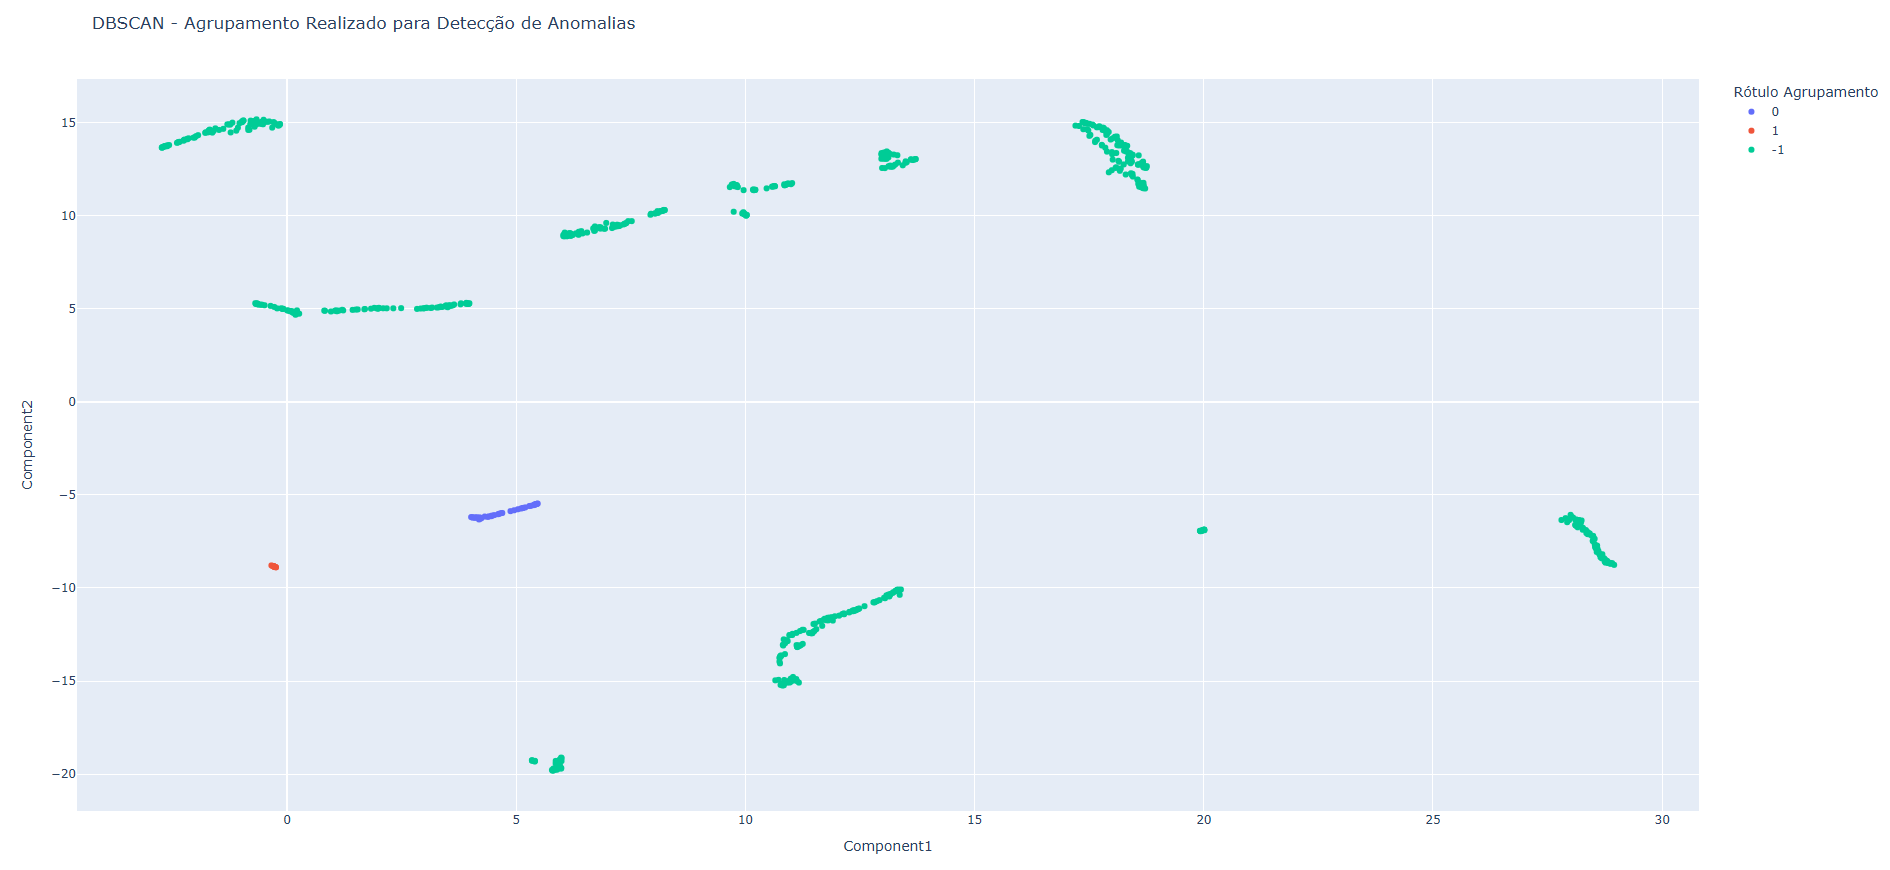

## Agrupamento de Regimes de Operação

Uma vez que foi possível distinguir regimes de operação normal de anômalas, o objetivo agora é conseguir distinguir os diversos regimes de operação rotulados. Dessa forma será possível identificar qual tipo de falhar o motor pode estar sofrendo.

In [ ]:
custom.settings = umap.defaults
custom.settings$n_neighbors = 10
custom.settings$metric = 'manhattan'
custom.settings$n_epochs = 5000
#custom.settings$min_dist= 0.0001
#custom.settings$n_components = 2

In [ ]:
dados.umap_scale <- umap(
    scale(dados[,3:dim(dados)[2]]), config=custom.settings)
dados.umap <- umap(
    dados[,3:dim(dados)[2]], config=custom.settings)

In [ ]:
summary(dados.umap$layout)

       V1                 V2          
 Min.   :-4.83750   Min.   :-8.28021  
 1st Qu.:-2.10114   1st Qu.:-2.79757  
 Median : 0.06392   Median :-0.00139  
 Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.: 2.07477   3rd Qu.: 3.22501  
 Max.   : 4.31574   Max.   : 7.56972  

In [ ]:
summary(dados.umap_scale$layout)

       V1                 V2          
 Min.   :-2.95593   Min.   :-3.74421  
 1st Qu.:-1.23385   1st Qu.:-1.47891  
 Median : 0.09719   Median : 0.05858  
 Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.: 1.24282   3rd Qu.: 1.41013  
 Max.   : 2.62497   Max.   : 3.88064  

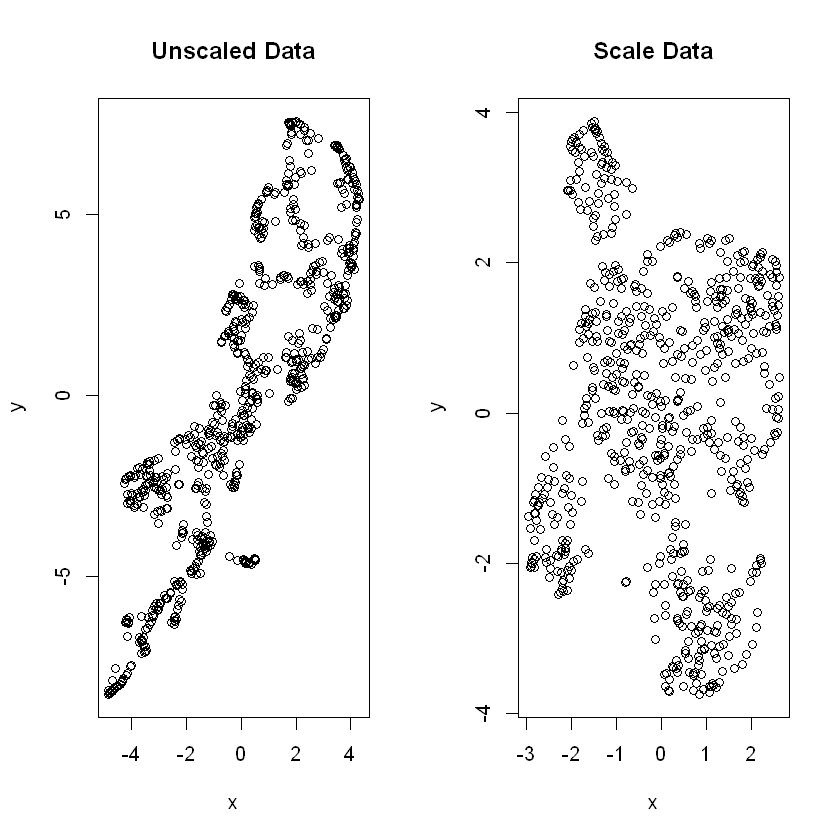

In [ ]:
#options(repr.plot.width = 1, repr.plot.height = 0.75)
par(mfrow = c(1, 2))
plot(dados.umap$layout, xlab='x', ylab='y', main="Unscaled Data" )
plot(dados.umap_scale$layout, xlab='x', ylab='y', main="Scale Data" )
par(mfrow = c(1, 1))

In [ ]:
dados2d <- cbind(dados[,1:2], as_tibble(dados.umap$layout), as_tibble(dados.umap_scale$layout))
colnames(dados2d) <- c('type', 'un', 'x_unscale', 'y_unscale', 'x_scale', 'y_scale')

Warning message:
"The `x` argument of `as_tibble.matrix()` must have unique column names if
`.name_repair` is omitted as of tibble 2.0.0.
i Using compatibility `.name_repair`."


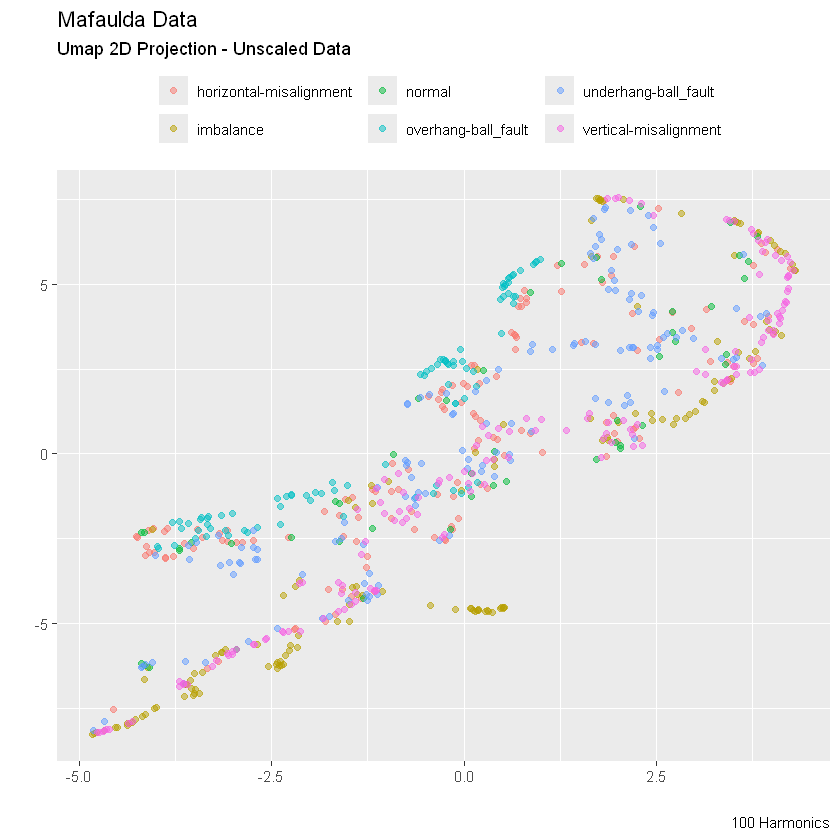

In [ ]:
plt1 <- dados2d %>%
    ggplot(aes(x=x_unscale, y=y_unscale, color=type)) +
    geom_point(alpha=0.5) +
    theme(legend.position = 'top') +
    labs(title='Mafaulda Data', subtitle = 'Umap 2D Projection - Unscaled Data', caption = '100 Harmonics') +
    xlab('') +
    ylab('') + theme(legend.title=element_blank())
print(plt1)

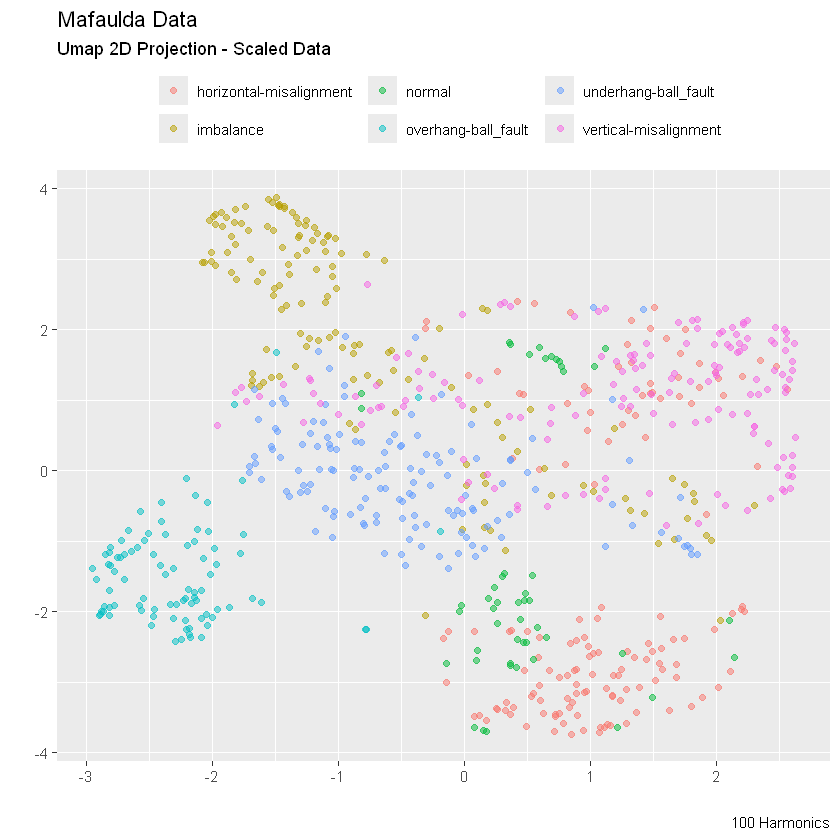

In [ ]:
plt2 <- dados2d %>%
    ggplot(aes(x=x_scale, y=y_scale, color=type)) +
    geom_point(alpha=0.5) +
    theme(legend.position = 'top') +
    labs(title='Mafaulda Data', subtitle = 'Umap 2D Projection - Scaled Data', caption = '100 Harmonics') +
    xlab('') +
    ylab('') + theme(legend.title=element_blank())
print(plt2)

Para realizar o agrupamento, foi escolhido o algoritmo K-Means.

O **K-Means** é um algoritmo de aprendizado não supervisionado usado para **agrupamento** (*clustering*). Ele particiona um conjunto de dados em **K clusters** distintos com base na proximidade dos pontos aos centróides, minimizando a variância intra-cluster.

---

## Funcionamento  

1. **Inicialização**:  
   - Escolha o número **K** de clusters desejados.  
   - Inicialize **K centróides** aleatoriamente ou por um método como *k-means++*.

2. **Iteração** (até convergência):  
   - **Passo 1: Atribuição**  
     Atribua cada ponto de dados \( x_i \) ao centróide mais próximo \( C_j \), onde a proximidade é calculada por uma **distância** (geralmente a distância Euclidiana):  
     \[
     d(x_i, C_j) = \| x_i - C_j \|_2^2
     \]
     Cada centróide representa o seu respectivo cluster.

   - **Passo 2: Atualização**  
     Recalcule os centróides como a **média aritmética** dos pontos atribuídos a cada cluster:  
     \[
     C_j = \frac{1}{|S_j|} \sum_{x \in S_j} x
     \]
     Onde \( S_j \) é o conjunto de pontos no cluster \( j \).

3. **Convergência**:  
   - O processo se repete até que os centróides não mudem significativamente ou uma condição de parada seja atingida (número máximo de iterações, por exemplo).  

---

## Fórmulas Matemáticas

O objetivo do algoritmo K-Means é **minimizar a soma dos erros quadráticos dentro dos clusters** (**Within-Cluster Sum of Squares**, WCSS):

\[
\text{WCSS} = \sum_{j=1}^K \sum_{x_i \in S_j} \| x_i - C_j \|^2
\]

Onde:  
- \( K \): número de clusters;  
- \( S_j \): conjunto de pontos atribuídos ao cluster \( j \);  
- \( C_j \): centróide do cluster \( j \).

---

## Vantagens  
- Simples e eficiente para conjuntos de dados grandes.  
- Convergência rápida em prática.  
- Fácil de interpretar e implementar.  

---

## Desvantagens  
- Sensível à inicialização dos centróides.  
- Assume que os clusters são esféricos e de tamanho semelhante.  
- Pode convergir para mínimos locais do WCSS.  
- O valor de \( K \) deve ser escolhido a priori.

---

## Aplicações  
- Compressão de imagens.  
- Segmentação de clientes (*Customer Segmentation*).  
- Agrupamento de documentos e textos.  
- Análise de padrões em grandes conjuntos de dados.

---

## Pseudocódigo  

```text
Entrada: Conjunto de dados X = {x_1, x_2, ..., x_n}, número de clusters K.
Saída: K clusters {C_1, C_2, ..., C_K}.

1. Inicialize K centróides aleatoriamente: C_1, C_2, ..., C_K.
2. Enquanto não convergir (ou atingir limite de iterações):
      a. Para cada ponto x_i em X:
            - Atribua x_i ao cluster com o centróide mais próximo.
      b. Para cada cluster C_j:
            - Recalcule o centróide como a média dos pontos atribuídos ao cluster.
3. Retorne os clusters e centróides finais.

In [ ]:
k <- kmeans(d_analise, 16)

In [ ]:
table(dados2d %>% pull(type), k$cluster)

                         
                           1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16
  horizontal-misalignment  5  0  0  2  2  0 20  0  0 24 42 29  0 16  5  2
  imbalance               12  0  0 30 15  2  0 70  5  3  0  1  0  0  1  0
  normal                   0  0  0  2  0  0 10  0  0 12  4  4  0  0 17  0
  overhang-ball_fault      0 32 27  3  0  1  0  0  1  0  0  0 22  0  2  0
  underhang-ball_fault    15  0  0 13 12 51  0  0 42  3  0  0  0  0  0  0
  vertical-misalignment   12  0  0 24 10  3  0  1  3 28  0  0  0 48  0 21

In [ ]:
table(paste(dados %>% pull(type), dados %>% pull(un)),  k$cluster)

                               
                                 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16
  horizontal-misalignment 1.0mm  0  0  0  0  0  0  9  0  0  0 20 17  0  0  3  0
  horizontal-misalignment 1.5mm  0  0  0  0  0  0 11  0  0  1 22 12  0  1  2  0
  horizontal-misalignment 2.0mm  5  0  0  2  2  0  0  0  0 23  0  0  0 15  0  2
  imbalance 25g                 10  0  0 23  9  0  0  1  1  2  0  0  0  0  1  0
  imbalance 30g                  1  0  0  4  4  1  0 33  3  1  0  0  0  0  0  0
  imbalance 35g                  1  0  0  3  2  1  0 36  1  0  0  1  0  0  0  0
  normal NA                      0  0  0  2  0  0 10  0  0 12  4  4  0  0 17  0
  overhang-ball_fault 20g        0  8 12  0  0  0  0  0  1  0  0  0  4  0  0  0
  overhang-ball_fault 35g        0  5  3  3  0  1  0  0  0  0  0  0  7  0  1  0
  overhang-ball_fault 6g         0 19 12  0  0  0  0  0  0  0  0  0 11  0  1  0
  underhang-ball_fault 20g       4  0  0  5  3 19  0  0 17  1  0  0  0  0  0  0
  underh

# Evaluation

Nota-se que os resultados obtidos pelo DBSCAN conseguiram identificar muito bem os clusters de operação normal. Uma parte dos dados de operação normal se distinguem da maioria, mas foram identificados com uma região próspera para um agrupamento. As demais amostras foram detectadas como ruídos, identificados pelo "-1", ou seja, regiões onde não foi possível identificar como pertencentes a nenhum agrupamento identificado, dados os parâmetros estabelecidos. Isso é interessante, pois os dados de operação normal não só se destacaram no espaço de atributos, como as demais anomalias foram identificadas como ruídos; esse evento pode ter ocorrido em virtude da normalização feita usando os dados de operação normal.

Alguns datapoints anômalos foram identificados como um pequeno agrupamento, mas impactaram pouco na performance obtida.

```
Adjusted Rand Index (ARI): 0.9921659194213989
Normalized Mutual Information (NMI): 0.9289064626944953
V-Measure: 0.9289064626944952
```

- O Rand Index faz parte da família de medidas pareadas, as quais podem usar tabelas de contingência para fazer o cálculo de forma mais eficiente. O Rand Index mede a fração dos verdadeiros positivos mais os verdadeiros negativos em razão de todas as amostras, retornando o "percentual de sucesso no agrupamento realizado". Aqui foi computada o Adjusted Rand Index (ARI), que segue o mesmo principio do Rand Index, mas para o ARI cada pra de datapoint `n_ij` é levado em conta na tabela de continência. São contados os pares designados à mesma classe ou classes diferentes:

    ``ARI = (RI - Expected_RI) / (max(RI) - Expected_RI)``

- A Informação Mutual Normalizada (NMI) tenta quantificar a quantidade de informação entre um agrupamento `C` e uma particionamento `T`, se a probabilidade conjugada de `p_ij` for nula então o agrupamento e partição são independentes. Ou seja, não há informação mutua entre os rótulo indicados no particionamento e os rótulos designados aos datapoints no agrupamento. 

    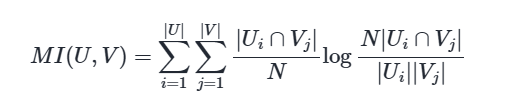

    Fonte: https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.mutual_info_score.html, acesso em 19/12/2024

    O NMI define uma média geométrica dessa informação compartilhada entre `C` e `T`.

    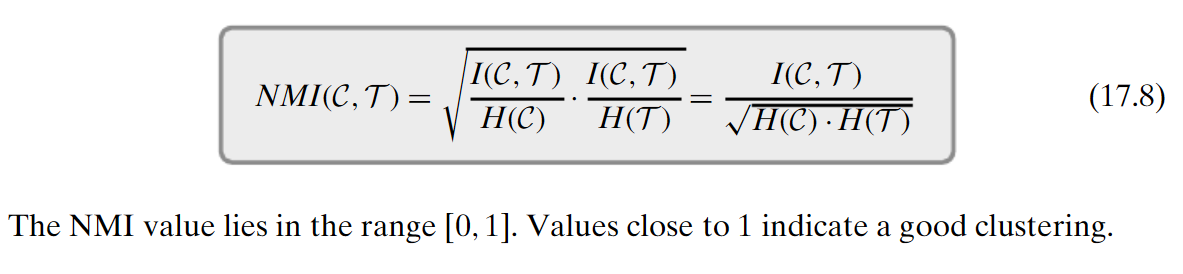

    Fonte: https://dataminingbook.info/book_html/chap17/book.html, acesso em 19/12/2024

- A V-Measure é calculada com base em duas quantidades: a homogeneidade e a completude do agrupamento, considerando rótulos verdadeiros.
    1. Homogeneidade: Um agrupamento é perfeitamente homogêneo se todos os seus clusters contiverem apenas amostras de uma única classe verdadeira.
Formalmente, a homogeneidade é definida por:

    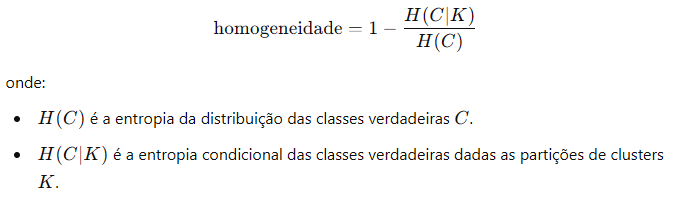

    2. Completude: Um agrupamento é completo se todas as amostras de uma classe verdadeira estiverem incluídas em um único cluster, sem se espalhar entre vários clusters.
Definida por:
    
    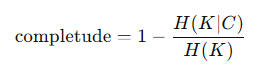
    
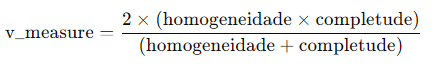

Caso o agrupamento "0" e "1" fossem unidos em um único grupo de operação normal, as métricas de qualidade indicariam que o agrupamento realizado foi ainda mais eficiente:

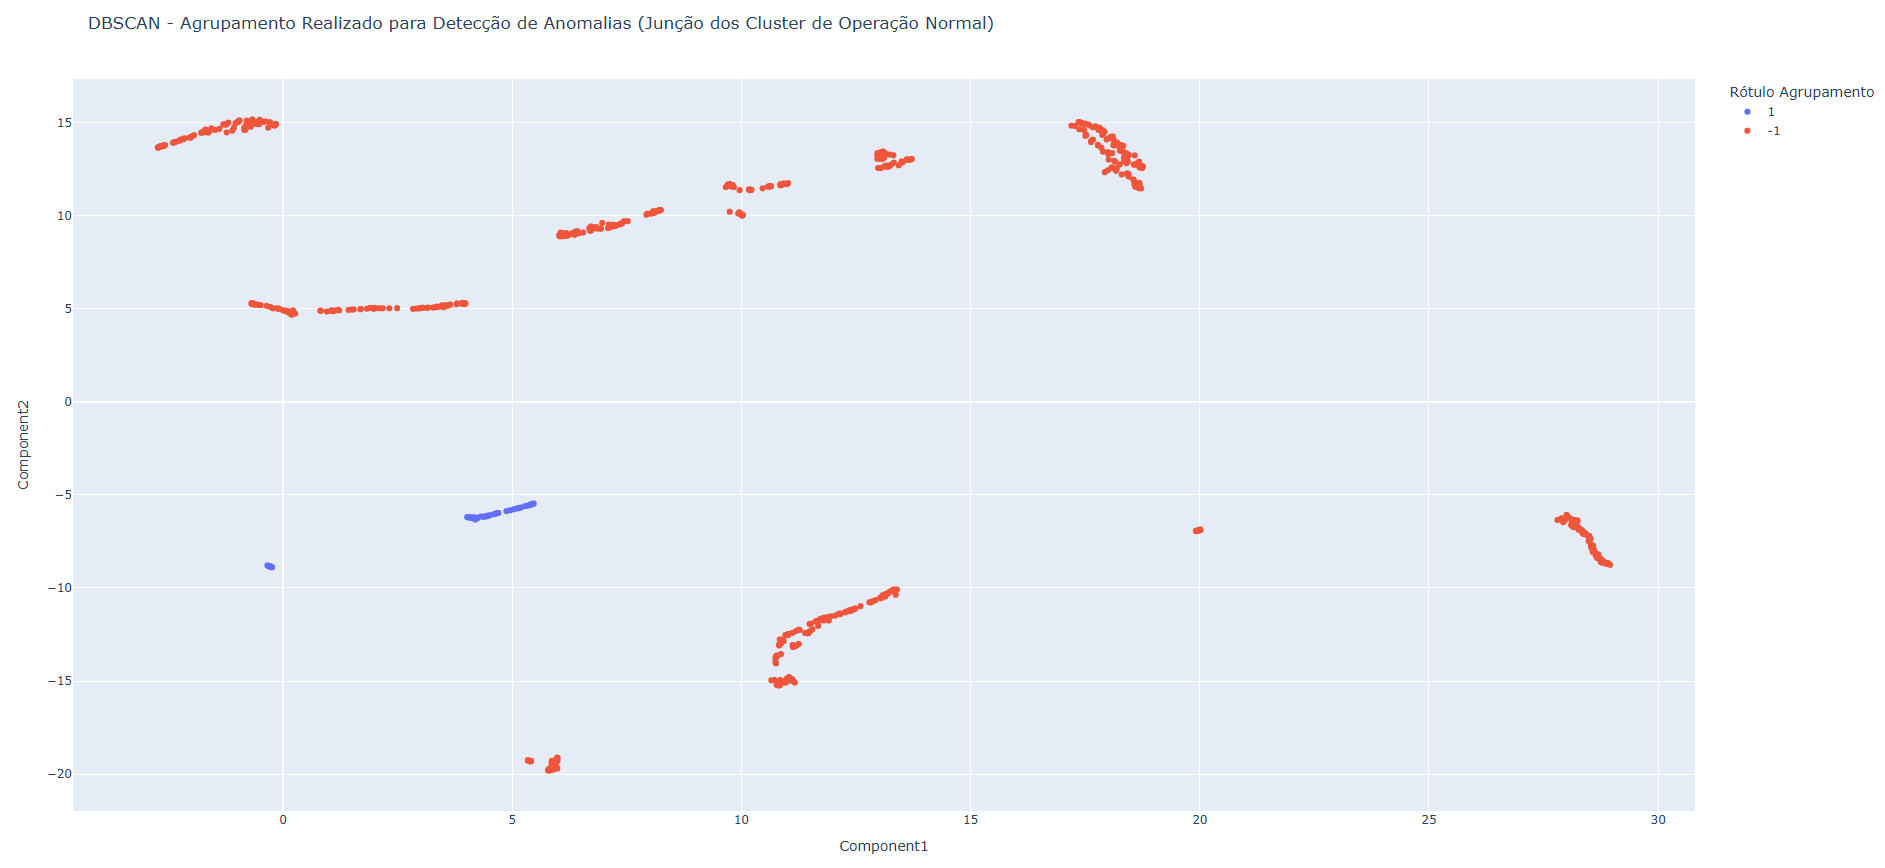

```
Adjusted Rand Index (ARI): 1.0
Normalized Mutual Information (NMI): 1.0
V-Measure: 1.0
```

Contudo, essas métricas de qualidade dizem respeito apenas a um método externo de avaliar o agrupamento, ou seja, usando um conhecimento prévio que se tem do conjunto de dados. Dessa forma pode-se comparar a performance do agrupamento dados os rótulos dos datapoints.

Existem outras formas de avaliar um agrupamento, tais como as medidas internas, as quais não consideram rótulos. Elas avaliam a qualidade do agrupamento, usando medidas internas que permitem obter noções da similaridade intracluster, mas também da qualidade da separação de cada agrupamento, avaliando a separação intercluster. O compromisso geralmente é maximizar esses dois critérios, indicando assim um melhor agrupamento.

```
davies_bouldin_score: 1.9533343437203896
silhouette_score: -0.5804783638834314
calinski_harabasz_score: 1.45821589912657
```

- O índice Davies-Bouldin (DB) avalia a qualidade do agrupamento com base na medida de dispersão dentro dos clusters e na separação entre eles, sem usar rótulos verdadeiros. Quanto menor o DB, melhor a separação e a compacidade do agrupamento.

    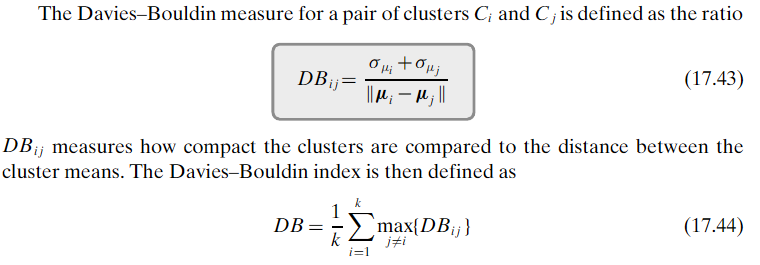
    
    Fonte: https://dataminingbook.info/book_html/chap17/book.html, acesso em 19/12/2024

- A silhueta quantifica o quão bem definido cada ponto está dentro do seu cluster. O silhouette_score geral é a média da silhueta de todas as amostras. Valores próximos de 1 indicam boa separação, enquanto valores próximos de -1 indicam mau agrupamento.

    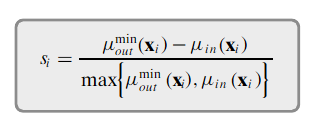

    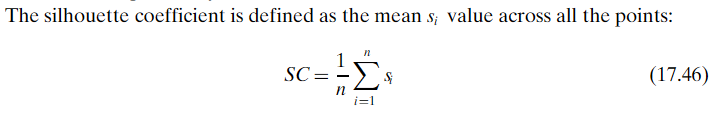

    Fonte: https://dataminingbook.info/book_html/chap17/book.html, acesso em 19/12/2024

- O índice Calinski-Harabasz (CH) compara a dispersão entre clusters com a dispersão interna dos clusters. Quanto maior o valor de CH, melhor a qualidade do agrupamento, pois indica maior separação entre clusters e menor dispersão interna.

    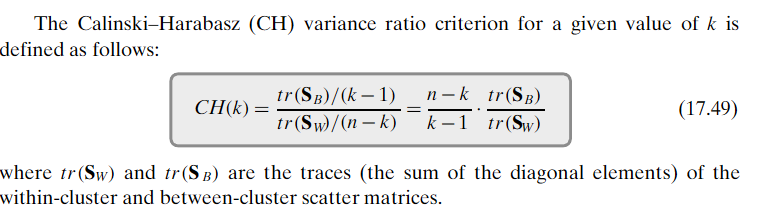

    Fonte: https://dataminingbook.info/book_html/chap17/book.html, acesso em 19/12/2024

É notável que os valores das métricas, na verdade, não indicam resultados bons. Analisando apenas no contexto de avaliar o intra e inter cluster, de fato o agrupamento não parece ser muito bem feito. A representação feita pelo UMAP indica claramente que existem regiões que potencialmente podem formar clusters adequados. No contexto das métricas externas os resultados foram excelentes, dados que a proposta inicial era detectar anomalias, mas olhando na perspectiva das métricas internas o agrupamento ficou a desejar.

Já ao avaliar a performance do agrupamento pelo regime de operação, nota-se que o K-Means consegue distinguir muito bem alguns dos regimes de operação dos demais. Mas a performance focou longe de estar perfeita, muitos dos regimes de operação ficaram em regiões onde era difícil estabelecer fronteiras que as segmenta-se bem.

```
                           1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16
  horizontal-misalignment  5  0  0  2  2  0 20  0  0 24 42 29  0 16  5  2
  imbalance               12  0  0 30 15  2  0 70  5  3  0  1  0  0  1  0
  normal                   0  0  0  2  0  0 10  0  0 12  4  4  0  0 17  0
  overhang-ball_fault      0 32 27  3  0  1  0  0  1  0  0  0 22  0  2  0
  underhang-ball_fault    15  0  0 13 12 51  0  0 42  3  0  0  0  0  0  0
  vertical-misalignment   12  0  0 24 10  3  0  1  3 28  0  0  0 48  0 21
```

Um dos principais desafios identificados é a **definição do número ideal de dimensões** para a execução eficiente do algoritmo. Nesse sentido, métodos baseados em **autoencoders de redes neurais** se destacam por possuírem processos de **otimização de metaparâmetros** integrados, o que oferece uma vantagem em relação a técnicas como **UMAP** ou **t-SNE**, que não incluem essa otimização de forma nativa.  

No que diz respeito aos dados analisados, observou-se uma **clara distinção** entre as classes **overhang-ball_fault** e **underhang-ball_fault** em comparação às demais classes. Contudo, no caso do **funcionamento normal do motor**, não foi identificada uma separação significativa em relação às demais condições. Isso revela uma dificuldade substancial em distinguir o **funcionamento normal** do motor de situações de **desbalanceamento** ou **desalinhamento**. Tal desafio representa um obstáculo importante para as equipes de engenharia no desenvolvimento de um **detector de falhas** eficaz para essa classe específica de mau funcionamento.

# Conclusão

O objetivo principal do trabalho era detectar anomalias no dados de medições de vibrações do motor, a base fornecia dados de alta qualidade com boa taxa de amostragem, sendo bem próspera para análises de harmônicos. As diferentes medições de vibração permitiram aplicar métodos como a FFT e Transformadas Wavelet para achar padrões no domínio do tempo e frequência que permitem distinguir bem os regimes de operação. Contudo, o processo de engenharia de atributos foi bem empírico, foram feitas várias interações e tentativas na busca de achar o melhor conjunto de atributos permitisse boa separação entre os regimes de operação do motor. Técnicas de redes neurais apresentam a vantagem de não haver necessidade de fazer engenharia de atributos de forma tão exaustiva, no processo de otimização dos parâmetros da rede, são "descobertos os kernels mais adequados" para montar um espaço de atributos adequado para a base.

No quesito de identificar anomalias, o método de normalização usando dados de operação normal, e aplicação do algoritmo DBSCAN permitiu separar bem dados de operação normal de anômalas. Sendo que, os dados anômalos foram considerados ruídos pelo algoritmo, portanto o objetivo principal foi alcançado com sucesso.

Já no processo de discernir cada uma das falhas foi mais desafiador, pois as fronteiras entre as anomalias não são tão claras, mesmo com os atributos estimados. Em alguns casos as anomalias se confundem, ficando "embaralhadas" no espaço de características. Contudo, algumas delas ficaram bem caracterizadas, sendo possível agrupá-las com precisão, separando-as da demais.